In [2]:
import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os.path

from os import getcwd
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import savemat, loadmat
import math
from scipy.fftpack import fft, ifft
from scipy.stats import zscore, f_oneway
#import samplerate
import multiprocessing as mp
from scipy.signal import resample
import random
import pyreadr
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import r2_score
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import NMF
import scipy.cluster.hierarchy as hac 
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import plotly.graph_objects as go
import plotly.express as px

In [3]:
def zscore_bseline(input_mat):
    use_unit_z = np.zeros(input_mat.shape)
    for item in range(input_mat.shape[0]):
        use_unit = input_mat[item]
        unit_baseline = use_unit[0:1500]
        unit_baseline_mean = np.mean(unit_baseline)
        unit_baseline_std = np.std(unit_baseline)
        use_unit_z[item] = (use_unit - unit_baseline_mean)/unit_baseline_std
    return use_unit_z

In [4]:
all_hg_ave_activity = loadmat("processed_data/all_cue_ecog.mat")
ecog_hg_onset_mean = all_hg_ave_activity['ecog_hg_onset_mean']
ecog_hg_onset_sem = all_hg_ave_activity['ecog_hg_onset_sem']
ecog_hg_sus_mean = all_hg_ave_activity['ecog_hg_sus_mean']
ecog_hg_sus_sem = all_hg_ave_activity['ecog_hg_sus_sem']
ecog_hg_three_mean = all_hg_ave_activity['ecog_hg_three_mean']
ecog_hg_three_sem = all_hg_ave_activity['ecog_hg_three_sem']

In [5]:
ecog_hg_mean = np.concatenate((ecog_hg_onset_mean, ecog_hg_sus_mean, ecog_hg_three_mean))
ecog_hg_mean.shape

ecog_hg_mean_z = zscore_bseline(ecog_hg_mean)

ecog_hg_good = np.delete(ecog_hg_mean_z, np.where((ecog_hg_mean_z[:, :1500] >= 5))[0], axis=0)
ecog_hg_good = ecog_hg_good - ecog_hg_good.min()


(220, 5000)

In [6]:
use_cmap = sns.choose_colorbrewer_palette('diverging')

interactive(children=(Dropdown(description='name', options=('RdBu', 'RdGy', 'PRGn', 'PiYG', 'BrBG', 'RdYlBu', …

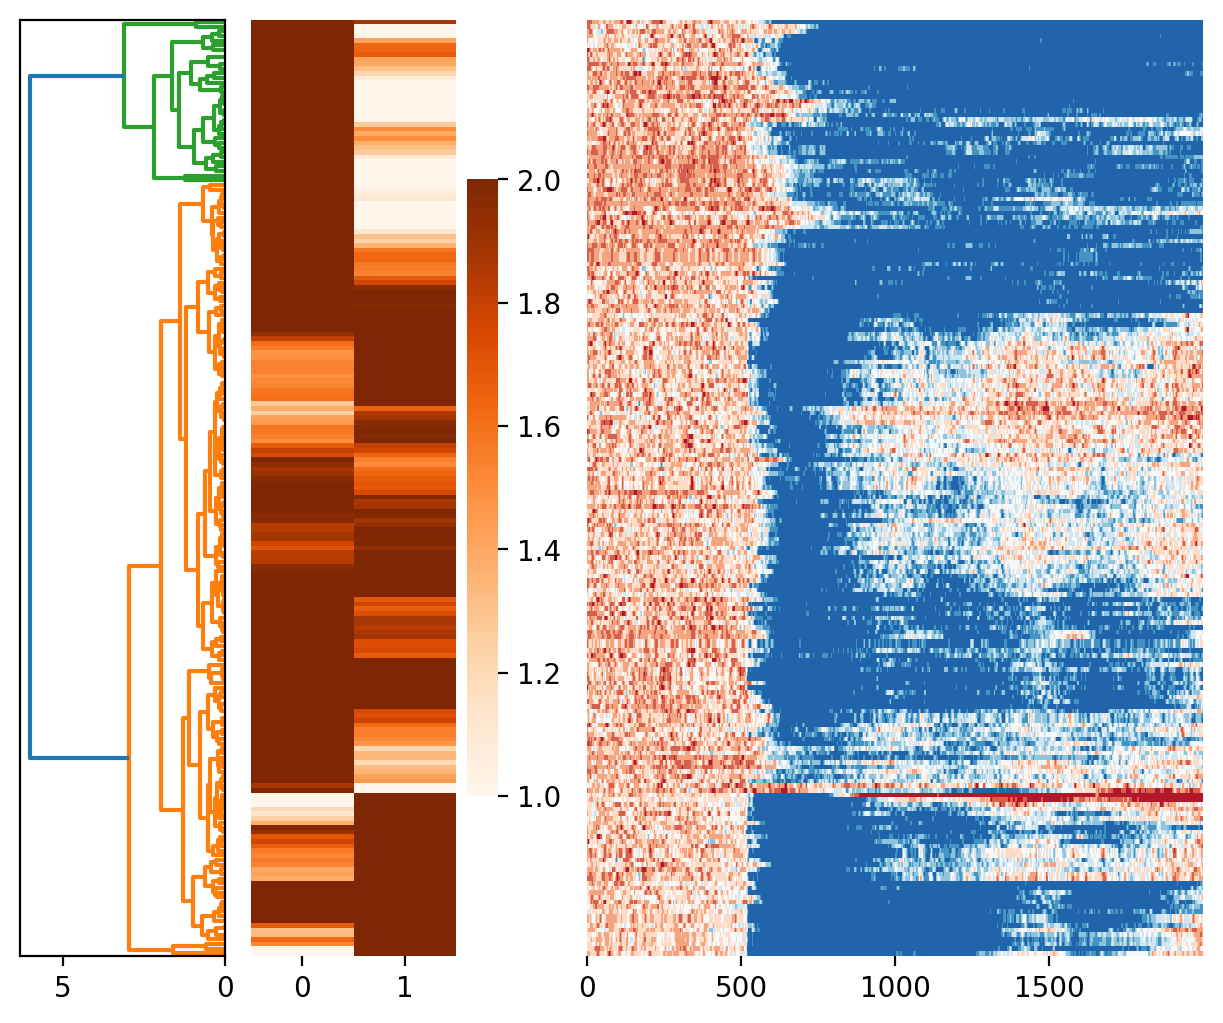

In [7]:
fig, axs = plt.subplots(1, 3, constrained_layout=True, 
                               figsize=(6, 5), dpi=200, 
                               gridspec_kw={'width_ratios': [1, 1, 3]})

NMF_input = ecog_hg_good[:, 1000:3000]
NMF_input = NMF_input - NMF_input.min()
model = NMF(n_components=2, init='random', 
            random_state=0, solver='mu', 
            beta_loss='frobenius', tol=0.0000001, 
            max_iter=250, alpha_W=0.01)
NMF_output = model.fit_transform(NMF_input)

Z = hac.linkage(NMF_output, 
                metric='euclidean', optimal_ordering=1, 
                method='weighted')
'''dn = hac.dendrogram(Z, get_leaves=1, ax=axs[0], 
                    orientation='left', no_labels=1, 
                    distance_sort=1, color_threshold=3, 
                    above_threshold_color="grey")'''

dn = hac.dendrogram(Z, get_leaves=1, ax=axs[0], 
                    orientation='left', no_labels=1, 
                    distance_sort=0)


NMF_reordere = np.zeros(NMF_output.shape)
for item in range(NMF_output.shape[0]):
    NMF_reordere[item] = NMF_output[dn['leaves'][item]]

sns.heatmap(NMF_reordere, ax=axs[1], 
            vmax=2, vmin=1, cmap='Oranges', 
            yticklabels=False) #

cos_ordered_units = np.zeros(ecog_hg_good.shape)
for item in range(ecog_hg_good.shape[0]):
    cos_ordered_units[item] = ecog_hg_good[dn['leaves'][item]]

sns.heatmap(zscore_bseline(cos_ordered_units)[:, 1000:3000], 
            cmap=use_cmap, cbar=False, 
            vmax=6, vmin=-3, ax=axs[2], 
            yticklabels=False, xticklabels=500)

plt.show();

In [7]:
from matplotlib import patches

In [8]:
ecog_hg_onset_red = np.repeat('Onset', ecog_hg_onset_mean.shape[0])
ecog_hg_sus_green = np.repeat('Sustained', ecog_hg_sus_mean.shape[0])
ecog_hg_three_blue = np.repeat('Syllable', ecog_hg_three_mean.shape[0])

ecog_hg_color_2 = np.concatenate((ecog_hg_sus_green, ecog_hg_onset_red))

In [9]:
leveles, categories = pd.factorize(ecog_hg_color_2)
colors = [plt.cm.tab10(i) for i in leveles]
handles = [patches.Patch(color=plt.cm.tab10(i), label=c) for i, c in enumerate(categories)]

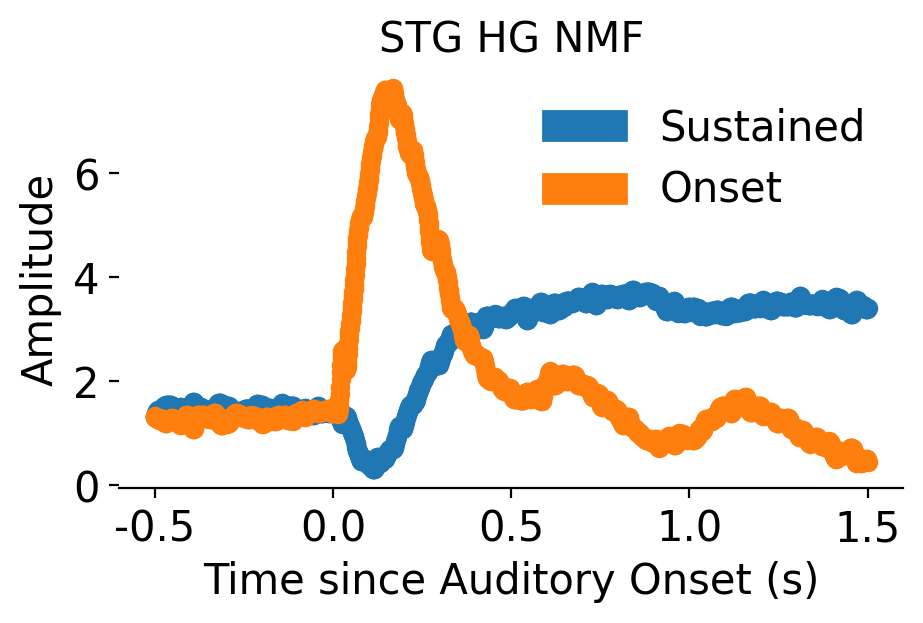

In [48]:
fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(4.5, 3), dpi=200)
axs.patch.set_alpha(0)
fig.patch.set_alpha(0)

x_lab = np.linspace(-0.5, 1.5, 2000)

plt.scatter(x=x_lab, y=model.components_[0], label='C1')
plt.scatter(x=x_lab, y=model.components_[1], label='C2')

axs.set_ylabel('Amplitude', fontsize=15)
axs.set_xlabel('Time since Auditory Onset (s)', fontsize=15)
legend = axs.legend(handles=handles, fontsize=15, frameon=False)
legend.get_frame().set_alpha(None)
sns.despine(ax=axs, top=True, right=True, left=True, bottom=False)
axs.set_xticks(np.linspace(-0.5, 1.5, 5))
axs.set_xticklabels(np.linspace(-0.5, 1.5, 5), fontsize=15)
axs.set_yticks(np.linspace(0, 6, 4))
axs.set_yticklabels(np.linspace(0, 6, 4, dtype=int), fontsize=15)
axs.set_title('STG HG NMF', fontsize=15)
plt.show();

IndexError: index 2 is out of bounds for axis 0 with size 2

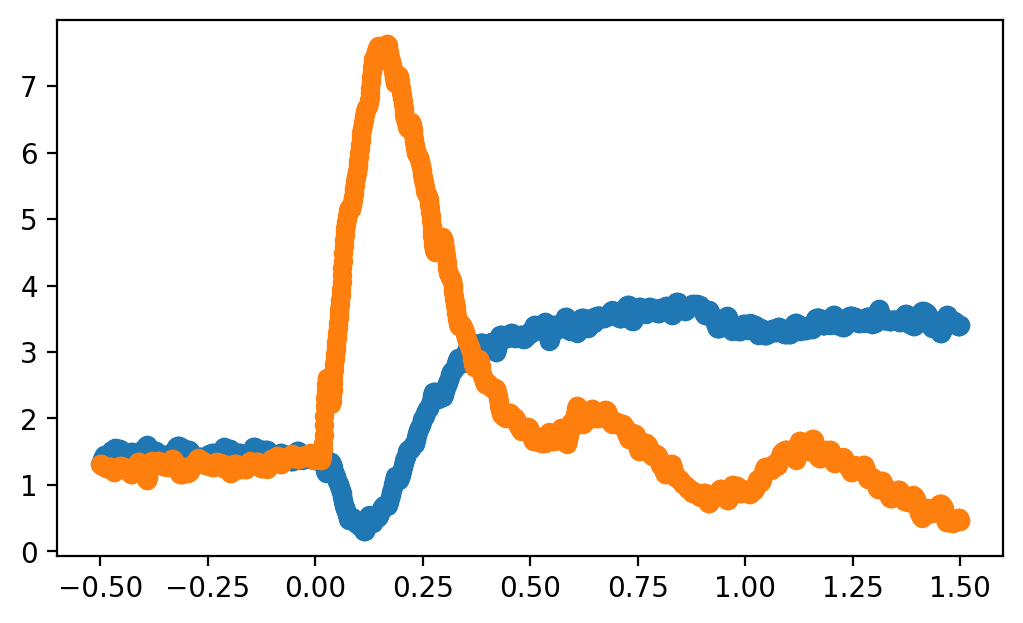

In [11]:
fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(5, 3), dpi=200)
axs.patch.set_alpha(0)
fig.patch.set_alpha(0)

x_lab = np.linspace(-0.5, 1.5, 2000)

plt.scatter(x=x_lab, y=model.components_[0], label='C1')
plt.scatter(x=x_lab, y=model.components_[1], label='C2')
plt.scatter(x=x_lab, y=model.components_[2], label='C3')
plt.scatter(x=x_lab, y=model.components_[3], label='C4')
#plt.scatter(x=x_lab, y=model.components_[4], label='C5')
#plt.scatter(x=x_lab, y=model.components_[5], label='C6')
#plt.scatter(x=x_lab, y=model.components_[6], label='C7')
#plt.scatter(x=x_lab, y=model.components_[7], label='C8')

plt.legend()
plt.show();

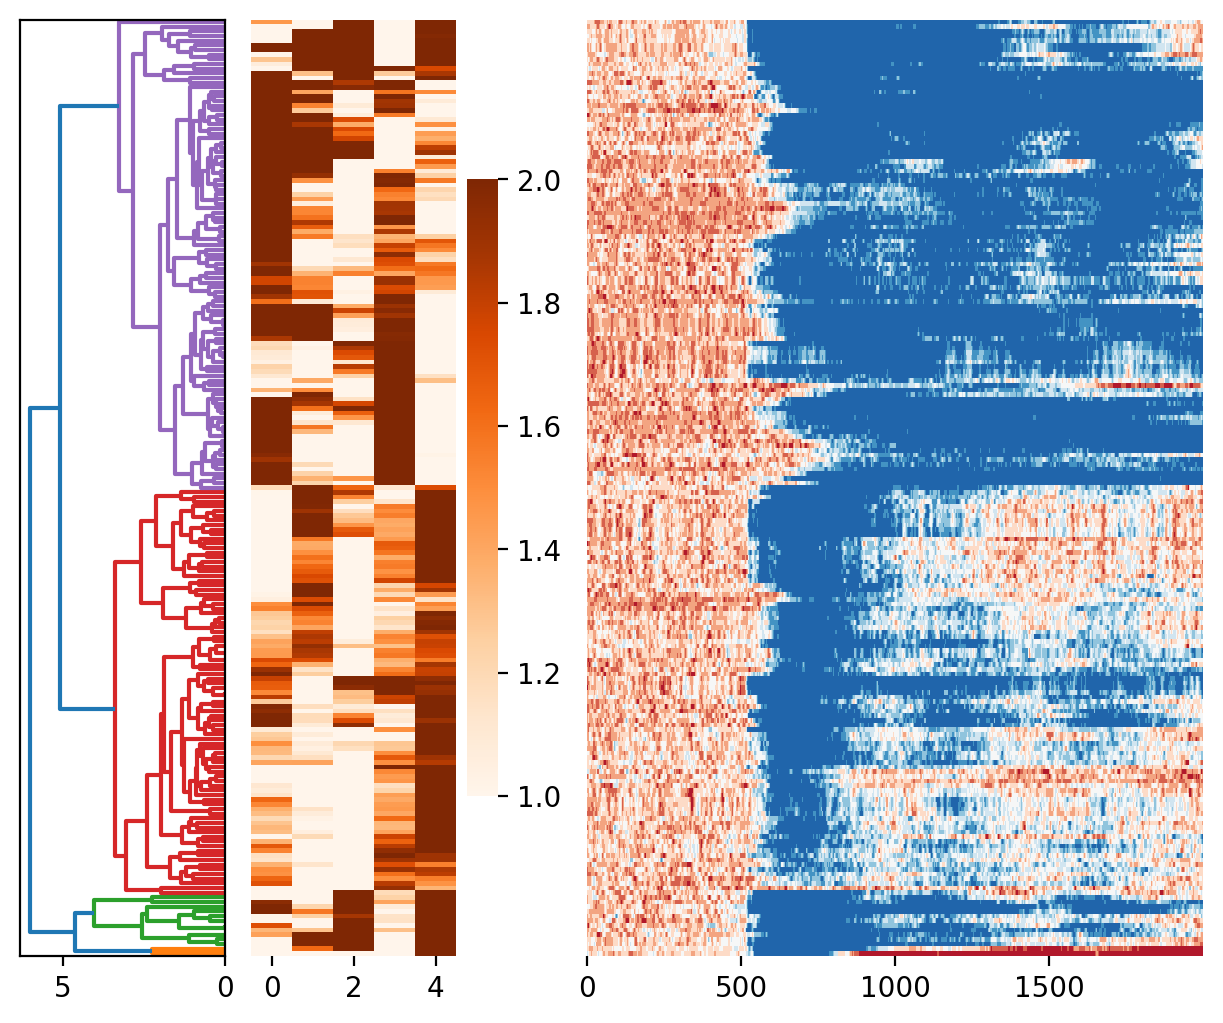

In [49]:
fig, axs = plt.subplots(1, 3, constrained_layout=True, 
                               figsize=(6, 5), dpi=200, 
                               gridspec_kw={'width_ratios': [1, 1, 3]})

NMF_input = ecog_hg_good[:, 1000:3000]
NMF_input = NMF_input - NMF_input.min()
model = NMF(n_components=5, init='random', 
            random_state=0, solver='mu', 
            beta_loss='frobenius', tol=0.0000001, 
            max_iter=250, alpha_W=0.01)
NMF_output = model.fit_transform(NMF_input)

Z = hac.linkage(NMF_output, 
                metric='euclidean', optimal_ordering=1, 
                method='weighted')
'''dn = hac.dendrogram(Z, get_leaves=1, ax=axs[0], 
                    orientation='left', no_labels=1, 
                    distance_sort=1, color_threshold=3, 
                    above_threshold_color="grey")'''

dn = hac.dendrogram(Z, get_leaves=1, ax=axs[0], 
                    orientation='left', no_labels=1, 
                    distance_sort=0)


NMF_reordere = np.zeros(NMF_output.shape)
for item in range(NMF_output.shape[0]):
    NMF_reordere[item] = NMF_output[dn['leaves'][item]]

sns.heatmap(NMF_reordere, ax=axs[1], 
            vmax=2, vmin=1, cmap='Oranges', 
            yticklabels=False) #

cos_ordered_units = np.zeros(ecog_hg_good.shape)
for item in range(ecog_hg_good.shape[0]):
    cos_ordered_units[item] = ecog_hg_good[dn['leaves'][item]]

sns.heatmap(zscore_bseline(cos_ordered_units)[:, 1000:3000], 
            cmap=use_cmap, cbar=False, 
            vmax=6, vmin=-3, ax=axs[2], 
            yticklabels=False, xticklabels=500)

plt.show();

In [11]:
NMF_input = ecog_hg_good[:, 1000:3000]
NMF_input = NMF_input - NMF_input.min()
model = NMF(n_components=4, init='random', 
            random_state=0, solver='mu', 
            beta_loss='frobenius', tol=0.0000001, 
            max_iter=250, alpha_W=0.01)
NMF_output = model.fit_transform(NMF_input)

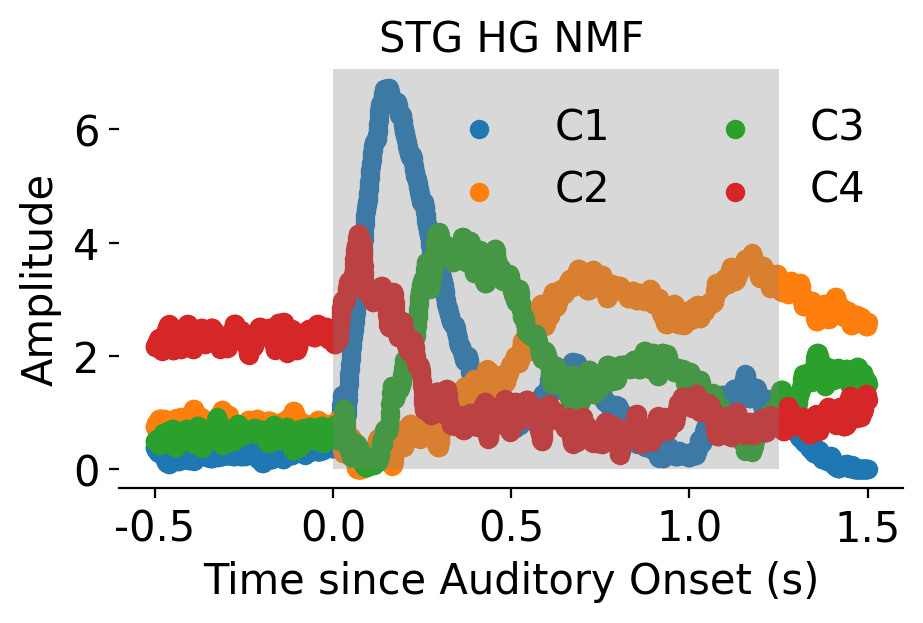

In [16]:
fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(4.5, 3), dpi=200)
axs.patch.set_alpha(0)
fig.patch.set_alpha(0)

x_lab = np.linspace(-0.5, 1.5, 2000)

plt.scatter(x=x_lab, y=model.components_[0], label='C1')
plt.scatter(x=x_lab, y=model.components_[1], label='C2')
plt.scatter(x=x_lab, y=model.components_[2], label='C3')
plt.scatter(x=x_lab, y=model.components_[3], label='C4')
#plt.scatter(x=x_lab, y=model.components_[4], label='C5')
#plt.scatter(x=x_lab, y=model.components_[5], label='C6')
#plt.scatter(x=x_lab, y=model.components_[6], label='C7')
#plt.scatter(x=x_lab, y=model.components_[7], label='C8')


axs.set_ylabel('Amplitude', fontsize=15)
axs.set_xlabel('Time since Auditory Onset (s)', fontsize=15)
legend = axs.legend(fontsize=15, frameon=False, ncol=2)
sns.despine(ax=axs, top=True, right=True, left=True, bottom=False)
axs.set_xticks(np.linspace(-0.5, 1.5, 5))
axs.set_xticklabels(np.linspace(-0.5, 1.5, 5), fontsize=15)
axs.set_yticks(np.linspace(0, 6, 4))
axs.set_yticklabels(np.linspace(0, 6, 4, dtype=int), fontsize=15)
axs.set_title('STG HG NMF', fontsize=15)

rect = patches.Rectangle((0, 0), 1.25, axs.get_ylim()[1], 
                         edgecolor='none', facecolor='grey', alpha=0.3)
axs.add_patch(rect)

plt.show();

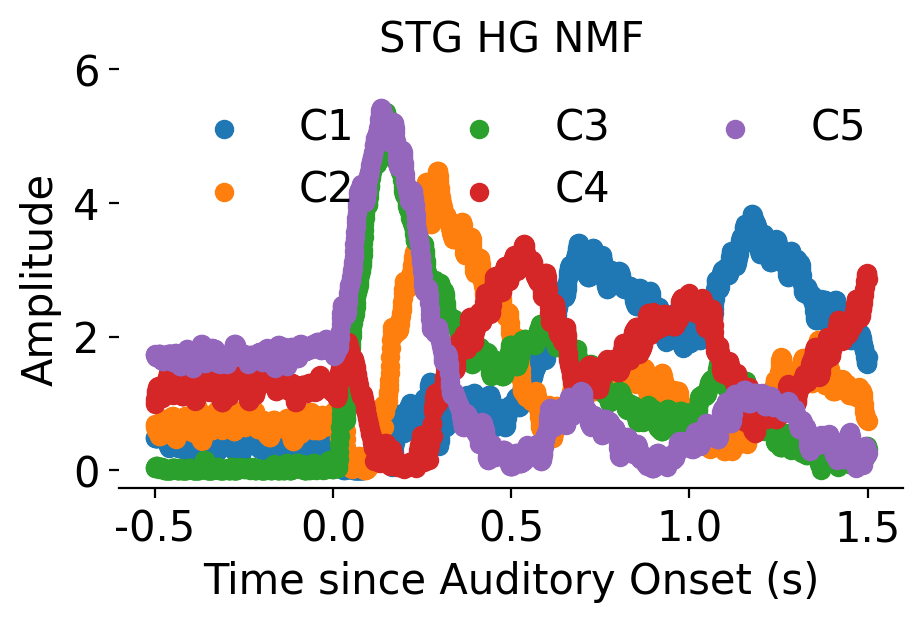

In [55]:
fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(4.5, 3), dpi=200)
axs.patch.set_alpha(0)
fig.patch.set_alpha(0)

x_lab = np.linspace(-0.5, 1.5, 2000)

plt.scatter(x=x_lab, y=model.components_[0], label='C1')
plt.scatter(x=x_lab, y=model.components_[1], label='C2')
plt.scatter(x=x_lab, y=model.components_[2], label='C3')
plt.scatter(x=x_lab, y=model.components_[3], label='C4')
plt.scatter(x=x_lab, y=model.components_[4], label='C5')
#plt.scatter(x=x_lab, y=model.components_[5], label='C6')
#plt.scatter(x=x_lab, y=model.components_[6], label='C7')
#plt.scatter(x=x_lab, y=model.components_[7], label='C8')


axs.set_ylabel('Amplitude', fontsize=15)
axs.set_xlabel('Time since Auditory Onset (s)', fontsize=15)
legend = axs.legend(fontsize=15, frameon=False, ncol=3)
sns.despine(ax=axs, top=True, right=True, left=True, bottom=False)
axs.set_xticks(np.linspace(-0.5, 1.5, 5))
axs.set_xticklabels(np.linspace(-0.5, 1.5, 5), fontsize=15)
axs.set_yticks(np.linspace(0, 6, 4))
axs.set_yticklabels(np.linspace(0, 6, 4, dtype=int), fontsize=15)
axs.set_title('STG HG NMF', fontsize=15)


plt.show();

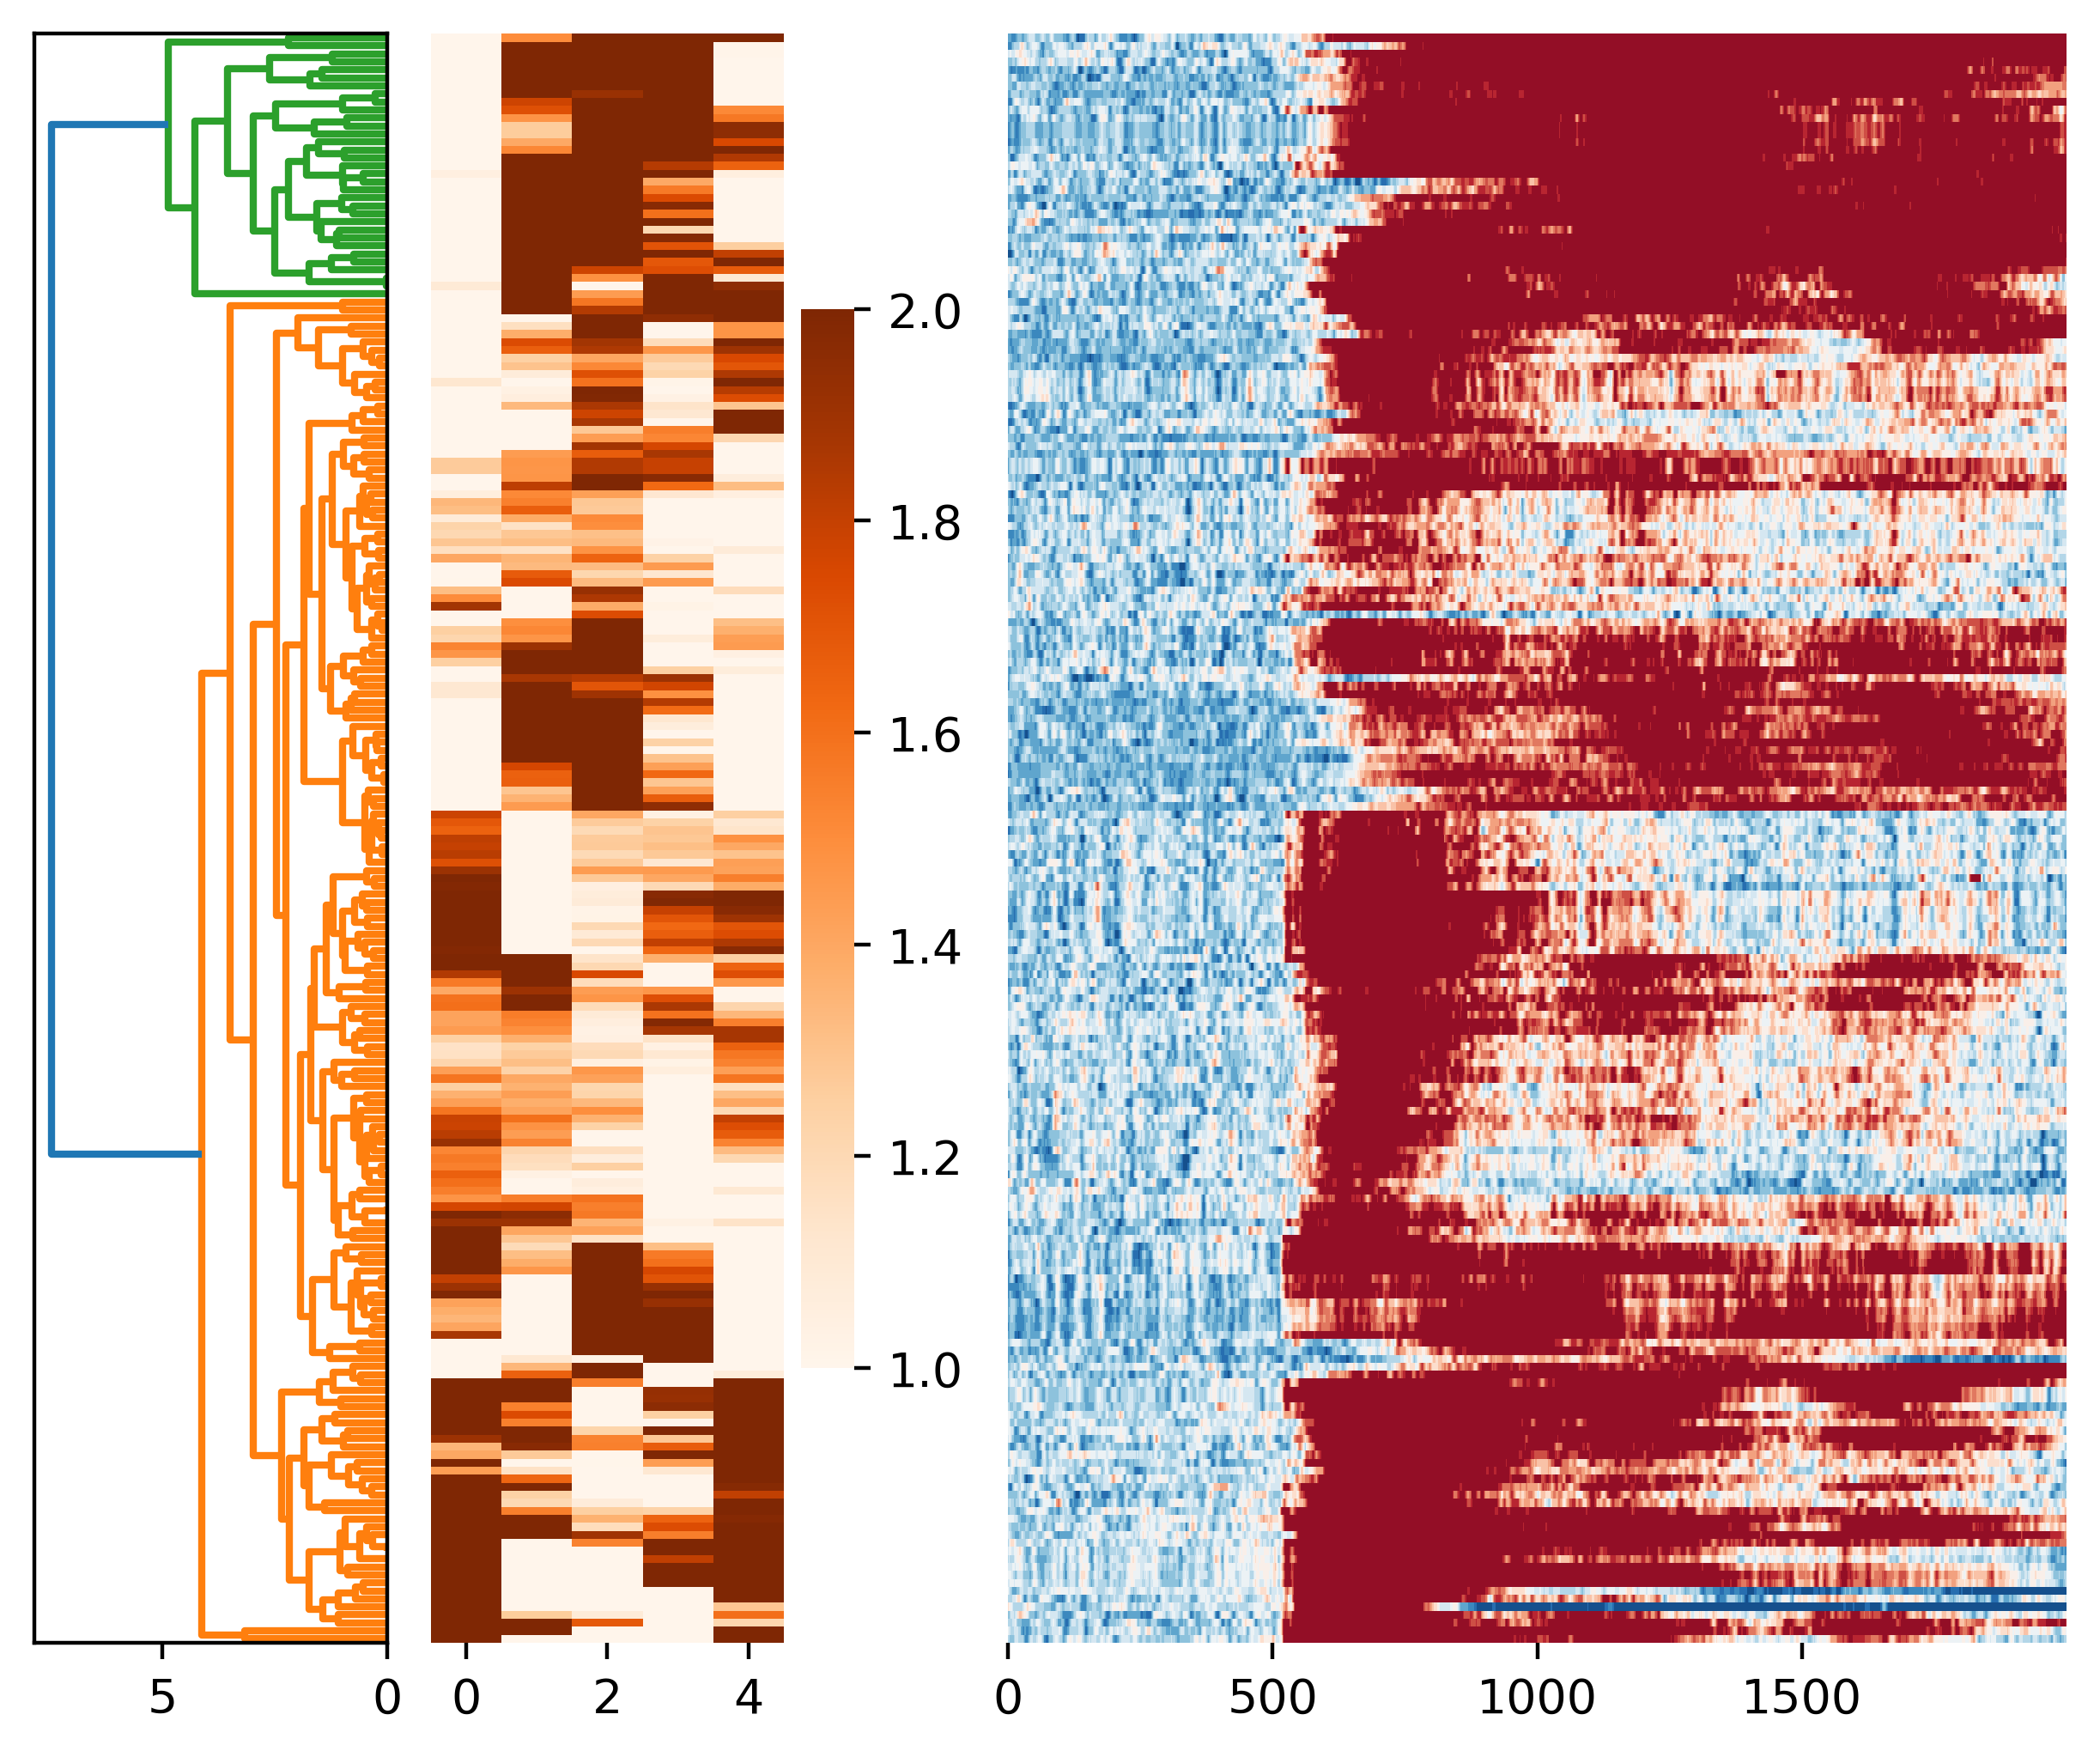

In [48]:
fig, axs = plt.subplots(1, 3, constrained_layout=True, 
                               figsize=(6, 5), dpi=200, 
                               gridspec_kw={'width_ratios': [1, 1, 3]})

NMF_input = ecog_hg_good[:, 1500:3000]
NMF_input = NMF_input - NMF_input.min()
model = NMF(n_components=5, init='random', 
            random_state=0, solver='mu', 
            beta_loss='frobenius', tol=0.0000001, 
            max_iter=250, alpha_W=0.2)
NMF_output = model.fit_transform(NMF_input)

Z = hac.linkage(NMF_output, 
                metric='euclidean', optimal_ordering=1, 
                method='weighted')
'''dn = hac.dendrogram(Z, get_leaves=1, ax=axs[0], 
                    orientation='left', no_labels=1, 
                    distance_sort=1, color_threshold=3, 
                    above_threshold_color="grey")'''

dn = hac.dendrogram(Z, get_leaves=1, ax=axs[0], 
                    orientation='left', no_labels=1, 
                    distance_sort=0)


NMF_reordere = np.zeros(NMF_output.shape)
for item in range(NMF_output.shape[0]):
    NMF_reordere[item] = NMF_output[dn['leaves'][item]]

sns.heatmap(NMF_reordere, ax=axs[1], 
            vmax=2, vmin=1, cmap='Oranges', 
            yticklabels=False) #

cos_ordered_units = np.zeros(ecog_hg_good.shape)
for item in range(ecog_hg_good.shape[0]):
    cos_ordered_units[item] = ecog_hg_good[dn['leaves'][item]]

sns.heatmap(zscore_bseline(cos_ordered_units)[:, 1000:3000], 
            cmap=use_cmap, cbar=False, 
            vmax=6, vmin=-3, ax=axs[2], 
            yticklabels=False, xticklabels=500)

plt.show();

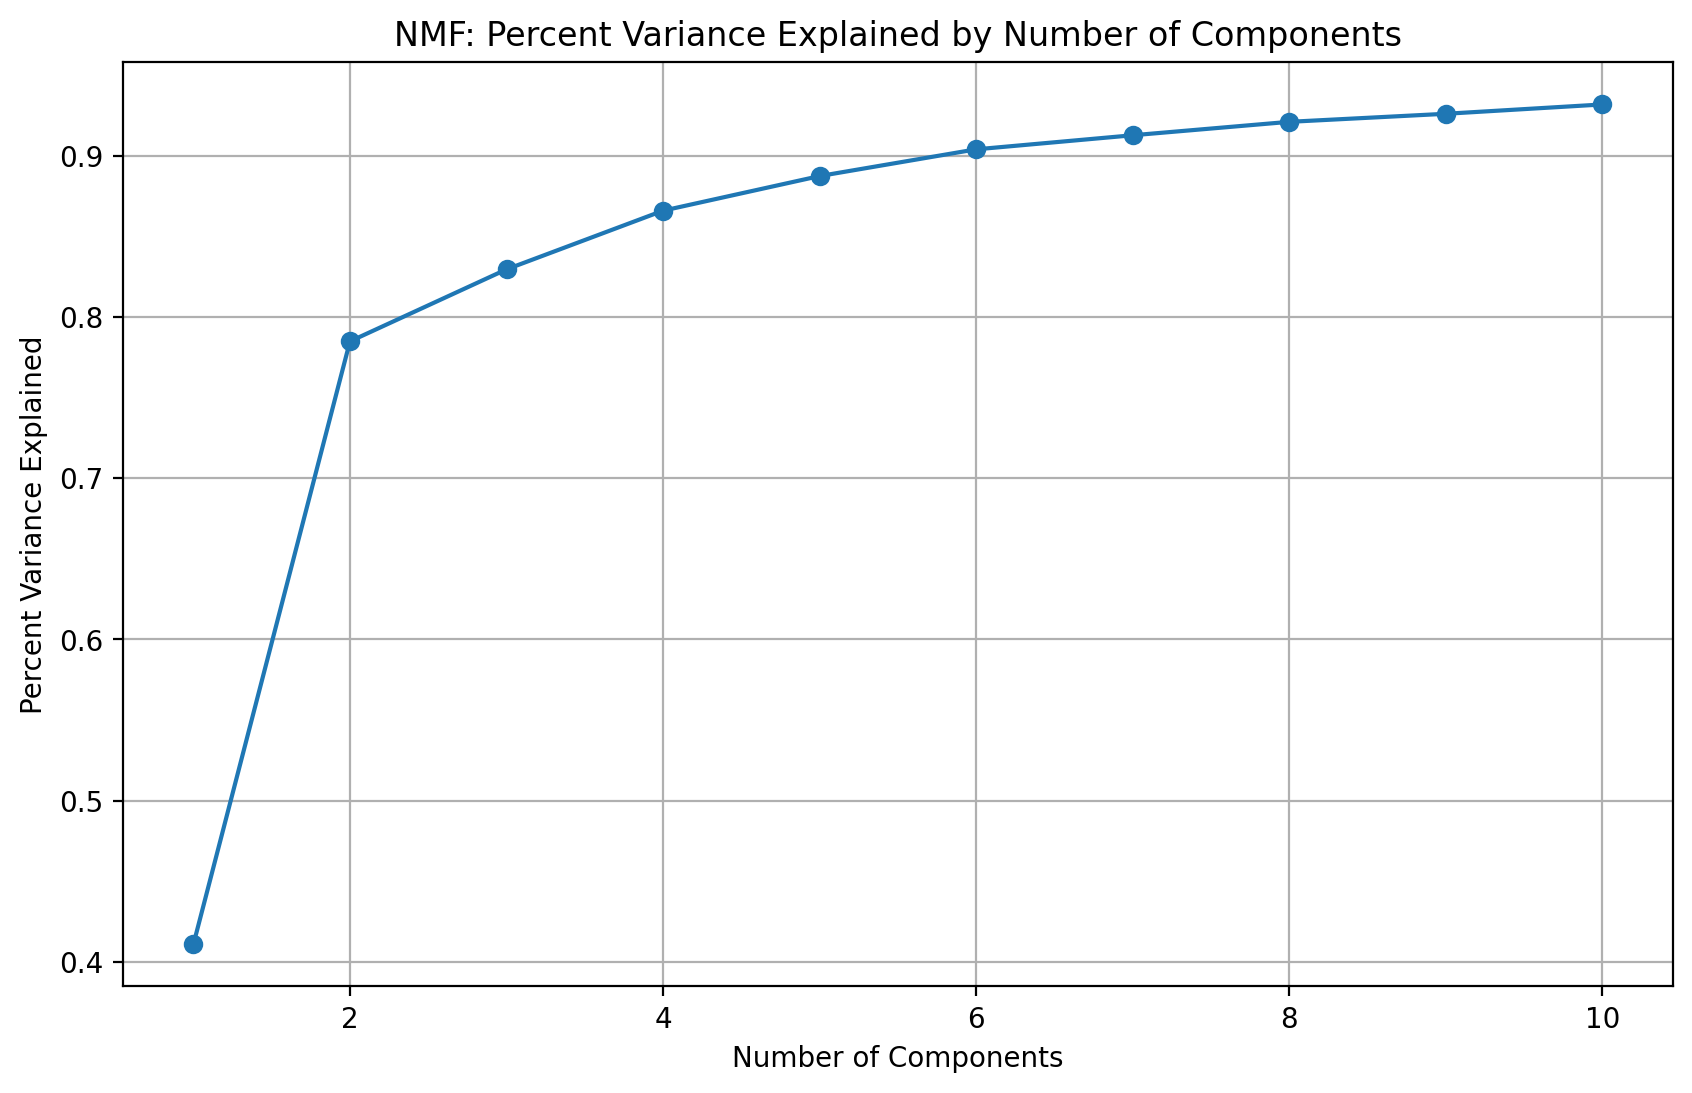

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from sklearn.preprocessing import StandardScaler

# Sample data (replace this with your actual dataset)
X_scaled = ecog_hg_good[:, 1000:3000]

# Calculate total variance
total_variance = np.sum(np.var(X_scaled, axis=0))

# Range of components to evaluate
n_components = range(1, 11)

# Store the results
explained_variances = []

for n in n_components:
    model = NMF(n_components=n, init='random', random_state=0)
    W = model.fit_transform(X_scaled)
    H = model.components_
    
    # Reconstruct the original data
    X_approx = np.dot(W, H)
    
    # Calculate explained variance
    explained_variance = np.sum(np.var(X_approx, axis=0))
    explained_variances.append(explained_variance / total_variance)

# Plotting the percent variance explained
plt.figure(figsize=(10, 6))
plt.plot(n_components, explained_variances, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Percent Variance Explained')
plt.title('NMF: Percent Variance Explained by Number of Components')
plt.grid(True)
plt.show();

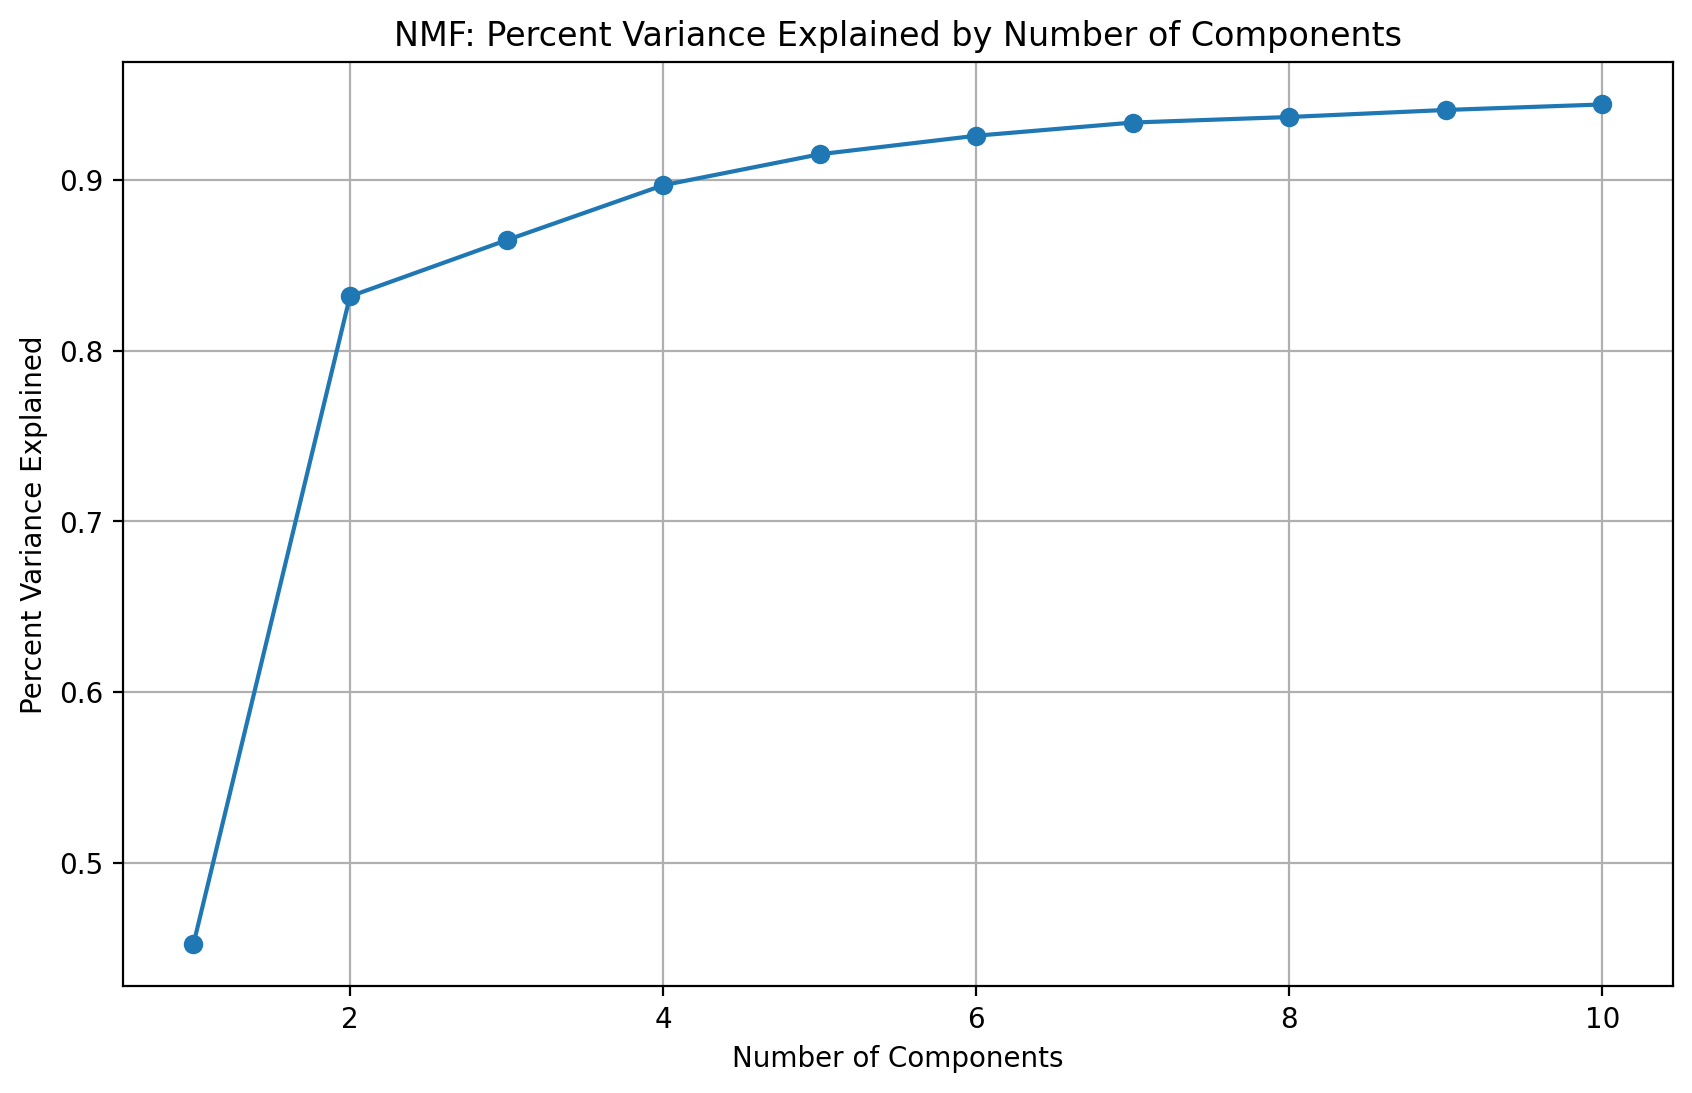

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from sklearn.preprocessing import StandardScaler

# Sample data (replace this with your actual dataset)
X_scaled = ecog_hg_good[:, 1500:3000]

# Calculate total variance
total_variance = np.sum(np.var(X_scaled, axis=0))

# Range of components to evaluate
n_components = range(1, 11)

# Store the results
explained_variances = []

for n in n_components:
    model = NMF(n_components=n, init='random', random_state=0)
    W = model.fit_transform(X_scaled)
    H = model.components_
    
    # Reconstruct the original data
    X_approx = np.dot(W, H)
    
    # Calculate explained variance
    explained_variance = np.sum(np.var(X_approx, axis=0))
    explained_variances.append(explained_variance / total_variance)

# Plotting the percent variance explained
plt.figure(figsize=(10, 6))
plt.plot(n_components, explained_variances, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Percent Variance Explained')
plt.title('NMF: Percent Variance Explained by Number of Components')
plt.grid(True)
plt.show();

In [12]:
import cvxpy as cp


In [43]:
def initialize_h(X, n_components):
    return np.random.rand(n_components, X.shape[1])

def update_w(X, H):
    n, m = X.shape
    r = H.shape[0]
    W = np.zeros((n, r))
    
    for i in range(n):
        # Solve for each row of W
        b = X[i, :]
        A = H.T
        w = np.linalg.lstsq(A, b, rcond=None)[0]
        w = np.clip(w, 0, None)  # Enforce non-negativity
        W[i, :] = w / np.sum(w)  # Normalize to ensure convex combination
    return W

def update_h(X, W, H):
    WH = W @ H
    H *= (W.T @ X) / (W.T @ WH + 1e-9)
    return H

def cnmf(X, n_components, max_iter=100):
    H = initialize_h(X, n_components)
    W = np.zeros((X.shape[0], n_components))  # Initial guess for W

    for i in range(max_iter):
        W = update_w(X, H)
        H = update_h(X, W, H)
    return W, H

# Example usage
X = ecog_hg_good[:, 1500:3000]  # CNMF requires non-negative data
n_components = 3
W, H = cnmf(X, n_components)

print(W.shape)
print(H.shape)

(201, 3)
(3, 1500)


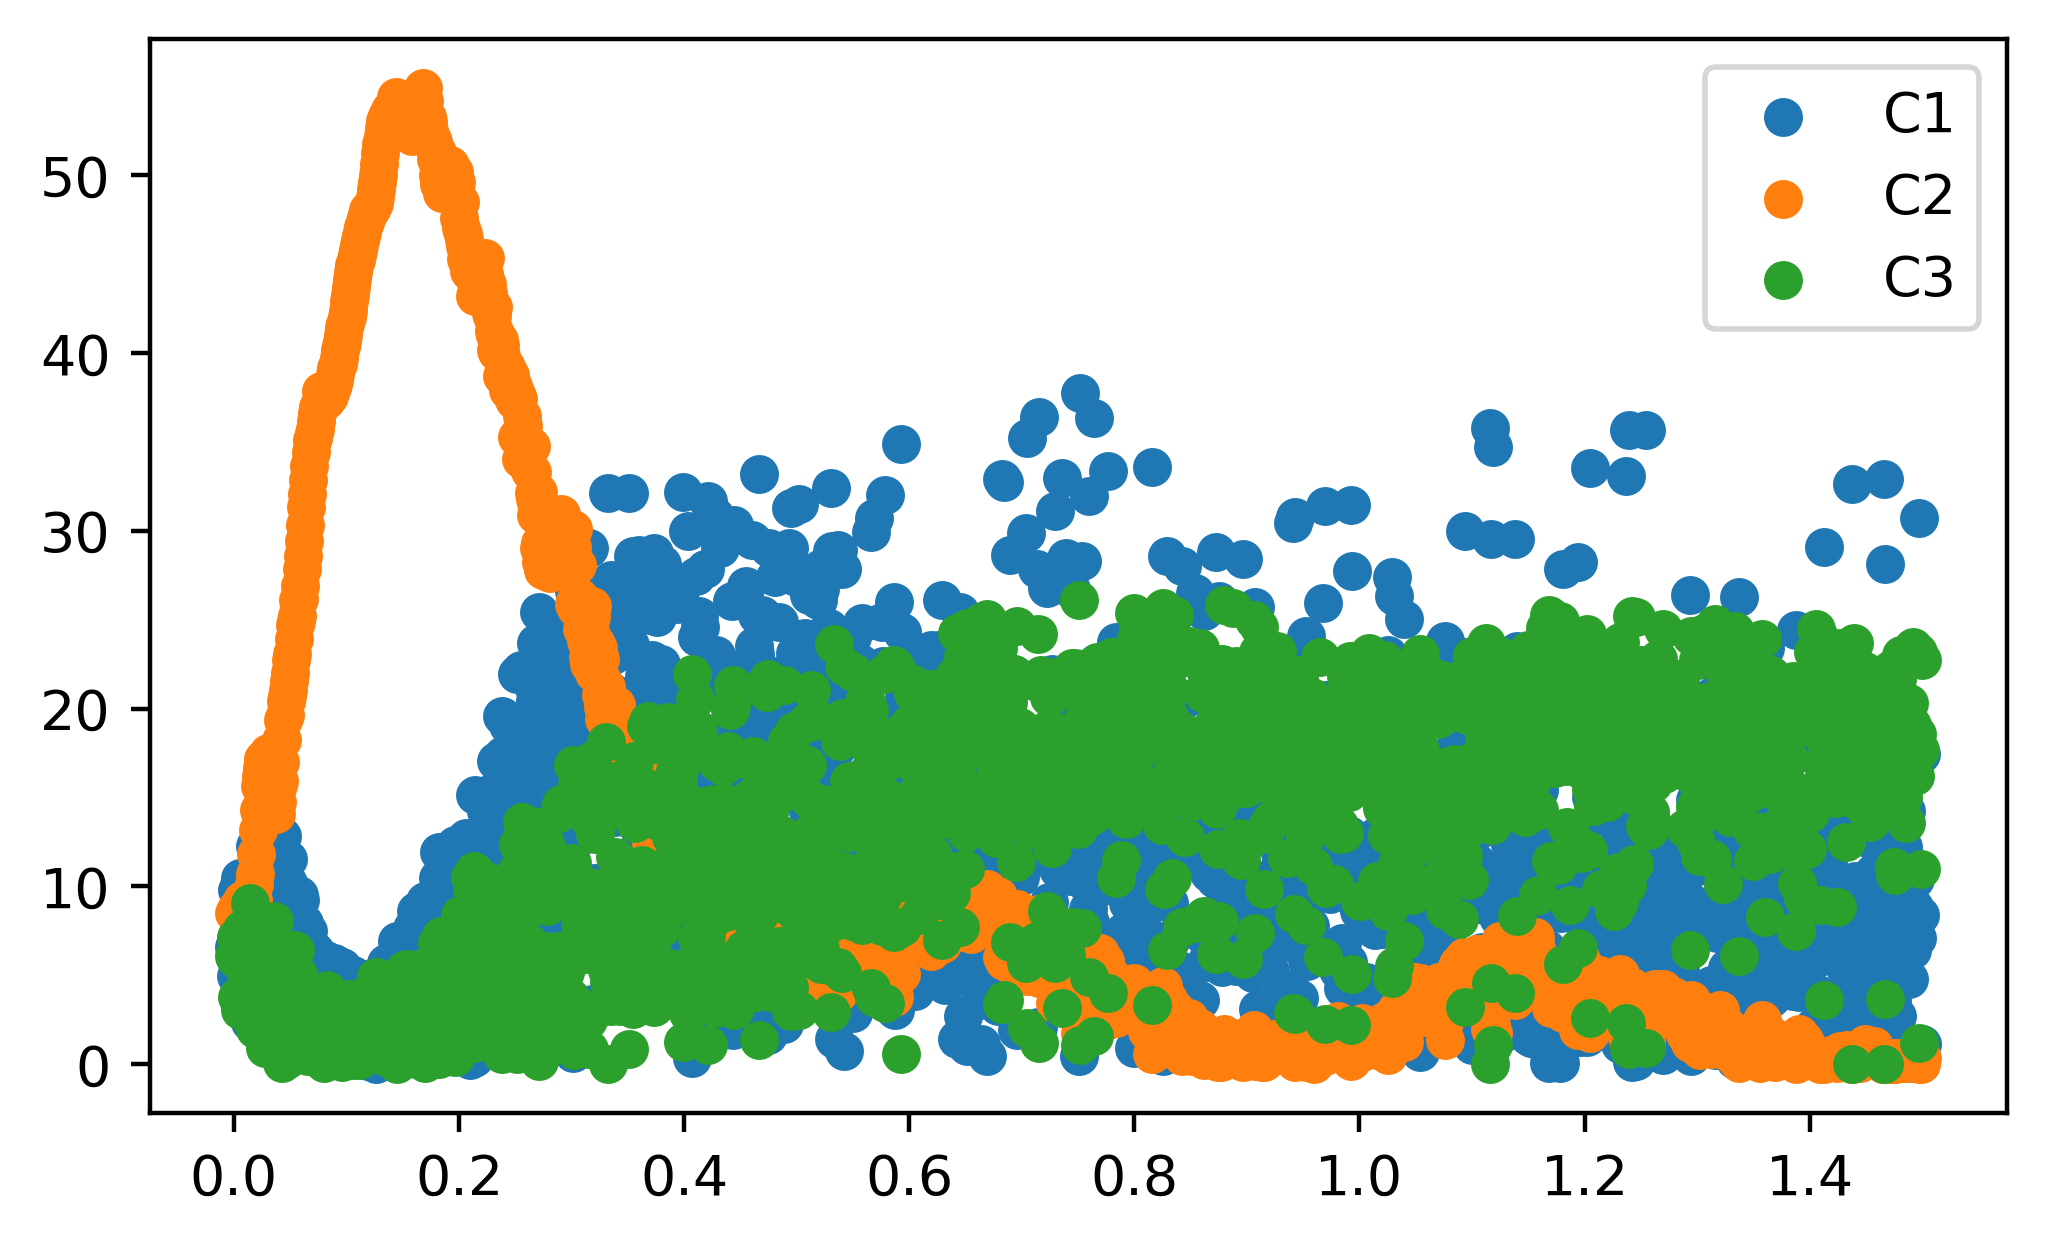

In [44]:
fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(5, 3), dpi=200)
axs.patch.set_alpha(0)
fig.patch.set_alpha(0)

x_lab = np.linspace(0, 1.5, 1500)

plt.scatter(x=x_lab, y=H[0], label='C1')
plt.scatter(x=x_lab, y=H[1], label='C2')
plt.scatter(x=x_lab, y=H[2], label='C3')
#plt.scatter(x=x_lab, y=H[3], label='C4')
#plt.scatter(x=x_lab, y=H[4], label='C5')
#plt.scatter(x=x_lab, y=H[5], label='C6')
#plt.scatter(x=x_lab, y=model.components_[6], label='C7')
#plt.scatter(x=x_lab, y=model.components_[7], label='C8')

plt.legend()
plt.show();

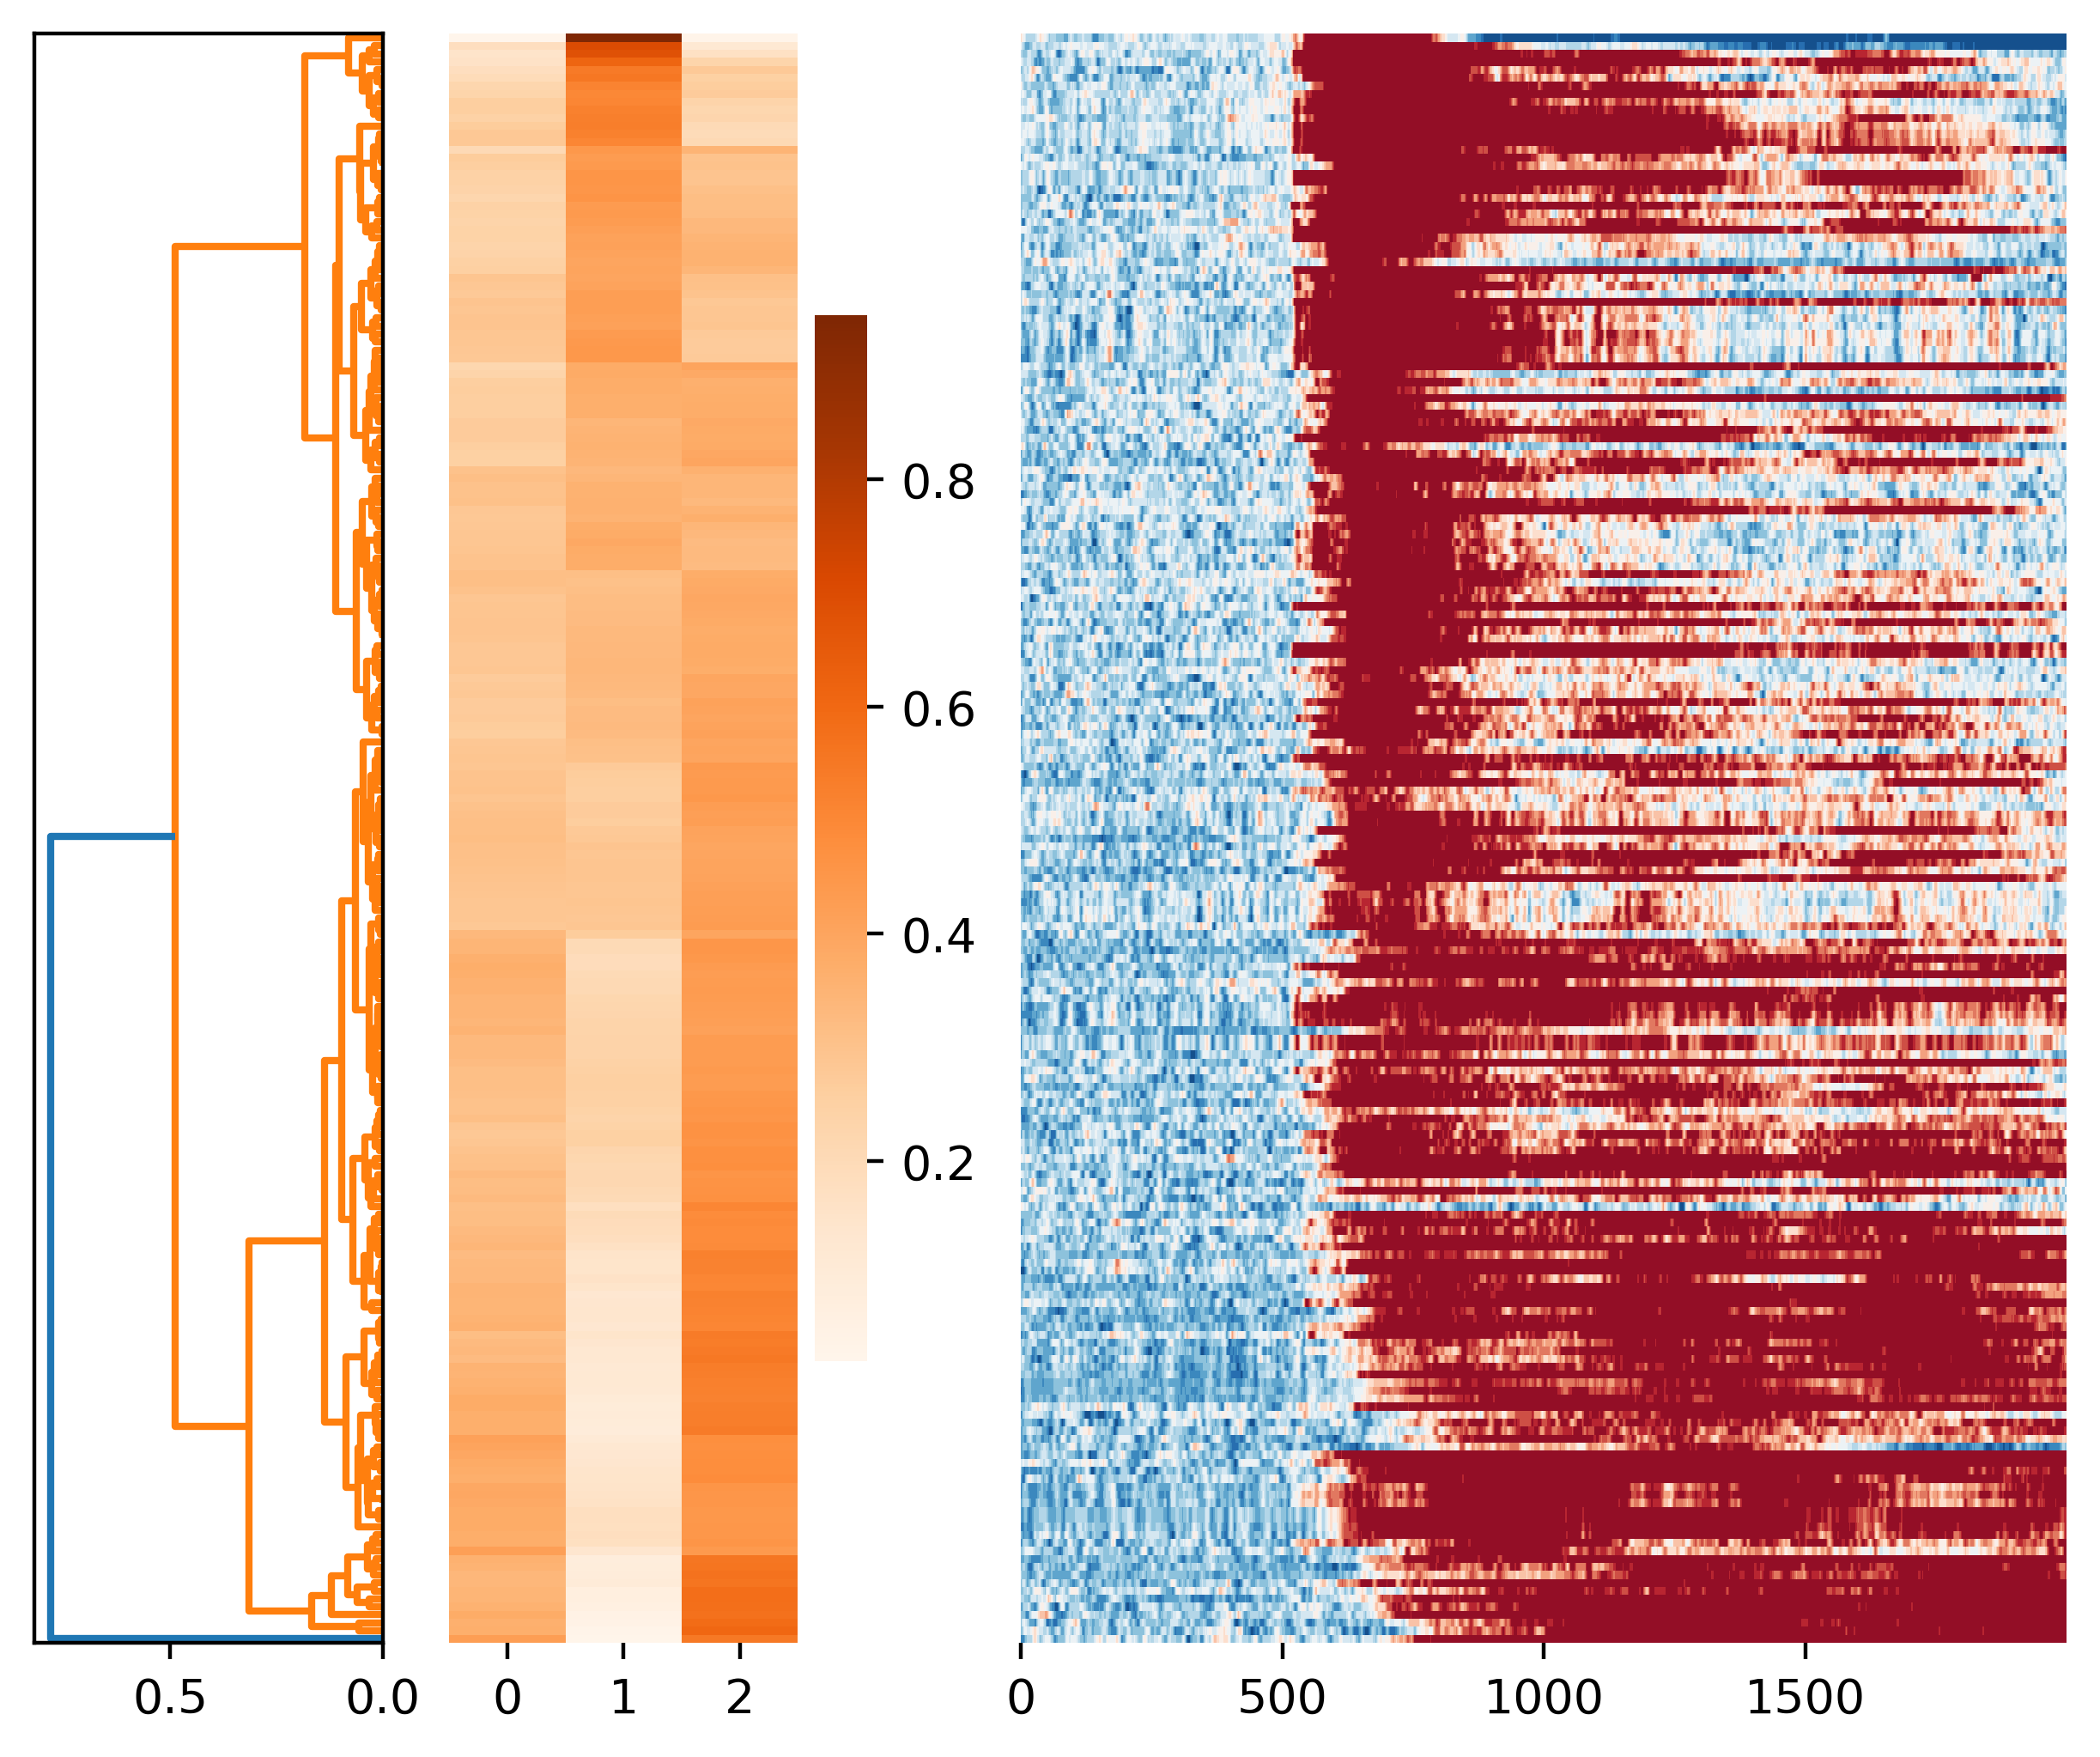

In [47]:
fig, axs = plt.subplots(1, 3, constrained_layout=True, 
                               figsize=(6, 5), dpi=200, 
                               gridspec_kw={'width_ratios': [1, 1, 3]})


NMF_output = W

Z = hac.linkage(NMF_output, 
                metric='euclidean', optimal_ordering=1, 
                method='weighted')
'''dn = hac.dendrogram(Z, get_leaves=1, ax=axs[0], 
                    orientation='left', no_labels=1, 
                    distance_sort=1, color_threshold=3, 
                    above_threshold_color="grey")'''

dn = hac.dendrogram(Z, get_leaves=1, ax=axs[0], 
                    orientation='left', no_labels=1, 
                    distance_sort=0)


NMF_reordere = np.zeros(NMF_output.shape)
for item in range(NMF_output.shape[0]):
    NMF_reordere[item] = NMF_output[dn['leaves'][item]]

sns.heatmap(NMF_reordere, ax=axs[1], cmap='Oranges', 
            yticklabels=False) #

cos_ordered_units = np.zeros(ecog_hg_good.shape)
for item in range(ecog_hg_good.shape[0]):
    cos_ordered_units[item] = ecog_hg_good[dn['leaves'][item]]

sns.heatmap(zscore_bseline(cos_ordered_units)[:, 1000:3000], 
            cmap=use_cmap, cbar=False, 
            vmax=6, vmin=-3, ax=axs[2], 
            yticklabels=False, xticklabels=500)

plt.show();

In [18]:
def calculate_variance_explained(X, W, H):
    # Calculate the reconstructed matrix
    X_approx = W @ H
    # Calculate the total variance of the original data
    total_variance = np.sum(np.var(X, axis=0))
    # Calculate the variance of the reconstructed data
    explained_variance = np.sum(np.var(X_approx, axis=0))
    # Calculate the percent variance explained
    return explained_variance / total_variance

In [12]:
X = ecog_hg_good[:, 1500:3000]

# Range of components to evaluate
component_range = range(1, 11)
variance_explained = []

for n_components in component_range:
    W, H = cnmf(X, n_components, max_iter=50)
    v_exp = calculate_variance_explained(X, W, H)
    variance_explained.append(v_exp)

# Plotting the percent variance explained
plt.figure(figsize=(10, 6))
plt.plot(component_range, variance_explained, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Percent Variance Explained')
plt.title('CNMF: Percent Variance Explained by Number of Components')
plt.grid(True)
plt.show();

NameError: name 'cnmf' is not defined